In [1]:
from typing import List

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression

from sklearn.decomposition import PCA

from sklearn.compose import ColumnTransformer

In [2]:
# Load data
url = "https://raw.githubusercontent.com/Tobias-Neubert94/adam_monk_II/master/adam_monk_II/data/Price_Data_Updated.gzip"
df = pd.read_parquet(url)
df.head()

,Ref_Date,Avg_Temperature_Berlin,Avg_Temperature_Cologne,Avg_Temperature_Frankfurt,Avg_Temperature_Hamburg,Avg_Temperature_Munich,Precipitation_Berlin,Precipitation_Cologne,Precipitation_Frankfurt,Precipitation_Hamburg,...,Hydro Pumped Storage,Hydro Run-of-river and poundage,Hydro Water Reservoir,Nuclear,Other,Other renewable,Solar,Waste,Wind Offshore,Wind Onshore
0,2003-01-02,5.6,11.1,10.4,1.2,11.6,17.6,11.9,29.3,8.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2003-01-03,0.5,8.1,8.5,-0.3,8.6,1.3,4.3,0.3,3.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2003-01-06,-4.7,-1.1,-2.0,-5.2,-4.2,0.2,0.6,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2003-01-07,-9.7,-3.8,-5.2,-9.3,-5.9,0.0,0.0,0.3,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2003-01-08,-10.0,-6.1,-8.0,-5.7,-8.1,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Rename columns to snake case and cleaner names
new_names = [
    "date",
    "temperature_berlin", "temperature_cologne", "temperature_frankfurt", "temperature_hamburg", "temperature_munich",
    "prep_berlin", "prep_cologne", "prep_frankfurt", "prep_hamburg", "prep_munich",
    "snow_berlin", "snow_cologne", "snow_frankfurt", "snow_hamburg", "snow_munich",
    "windspeed_berlin", "windspeed_cologne", "windspeed_frankfurt", "windspeed_hamburg", "windspeed_munich",
    "irradiation_berlin", "irradiation_cologne", "irradiation_frankfurt", "irradiation_hamburg", "irradiation_munich",
    "future_price",
    "gen_biomass",
    "gen_ff_browncoallignite",
    "gen_ff_coalderivedgas",
    "gen_fossilgas",
    "gen_fossilhardcoal",
    "gen_fossiloil",
    "gen_geothermal",
    "gen_hydropumpedstorage",
    "gen_hydrorunofriver",
    "gen_hydrowaterreservoir",
    "gen_nuclear",
    "gen_other",
    "gen_otherrenewable",
    "gen_solar",
    "gen_waste",
    "gen_windoffshore",
    "gen_windonshore",
]
df.columns = new_names

In [4]:
# Set target at end of dataframe
df = df[[c for c in df.columns if c != "future_price"] + ["future_price"]]

In [5]:
# Filter dataset for years 2015+ as generation data is not available as far back as 2003
df = df[df.date.dt.year >= 2015]

# Preprocessing

## Addressing null values

In [6]:
print("These are the columns with null values:")
df.loc[:, df.isnull().sum() > 0].isnull().sum().sort_values(ascending=False)

These are the columns with null values:


snow_munich           654
snow_berlin           356
irradiation_berlin     79
windspeed_munich       37
snow_cologne            5
dtype: int64

We notice there are null values reported for Berlin and Munich across multiple weather measures (snow & irradiation for Berlin), (windspeed & snow for Munich).
Let's check how many dates report NULL for both technologies at the same time to consider whether some rows should be dropped. 

In [7]:
df[
    (df.snow_berlin.isnull())
    & (df.irradiation_berlin.isnull())
][
    ["date"] + [col for col in df.columns if "berlin" in col]
]
# only six rows for berlin - fine to impute values

,date,temperature_berlin,prep_berlin,snow_berlin,windspeed_berlin,irradiation_berlin
4742,2022-09-12,14.8,0.0,NaN,7.1,NaN
4743,2022-09-13,15.7,1.5,NaN,13.1,NaN
4744,2022-09-14,14.3,0.0,NaN,10.5,NaN
4746,2022-09-16,12.8,3.2,NaN,20.7,NaN
4747,2022-09-19,10.2,10.0,NaN,15.2,NaN
4748,2022-09-20,10.0,5.5,NaN,12.9,NaN


In [8]:
df[
    (df.windspeed_munich.isnull())
    & (df.snow_munich.isnull())
][
    ["date"] + [col for col in df.columns if "munich" in col]
]
# only one row for munich - even better

,date,temperature_munich,prep_munich,snow_munich,windspeed_munich,irradiation_munich
3206,2016-09-05,16.0,0.8,NaN,NaN,270.0


### Snow

Values are most frequently missing for snowfall. Let's assume snowfall is relevant mostly for winter months (10-2), and research when snowfall values are missing. Ideally they should be in the spring/summer months (3-9), with an even spread across years.

In [10]:
df[
    (df.snow_munich.isnull())
    | (df.snow_berlin.isnull())
    | (df.snow_cologne.isnull())
][["date", "snow_munich", "snow_berlin", "snow_cologne"]].groupby([df.date.dt.year, df.date.dt.month]).count()

# This looks good - across years, evenly missing mostly between months 5-9.

date  snow_munich  snow_berlin  snow_cologne
date date                                              
2015 5       19            0           19            19
     6       22            0           22            22
     7       23            0           23            23
     8       21            0           21            21
     9       22            0           22            22
2016 5       22            0           22            22
     6       22            0           22            22
     7       21            0           21            21
     8       23            0           23            23
     9       22            0           22            22
2017 5       22            0           22            22
     6       22            0           22            22
     7       21            0           21            21
     8       23            0           23            23
     9       21            0           21            21
2018 5       22            0           22            22
     6       21            0           21            21
     7       22            0           22            22
     8       23            0           23            23
     9       20            0           20            20
2019 5       22            0           22            22
     6       20            0           20            20
     7       23            0           23            23
     8       22            0           22            22
     9       21            0           21            21
2020 5       20            0           20            20
     6       22            0           22            22
     7       23            0           23            23
     8       21            0           21            21
     9       22            0           22            22
2021 5       19           19            0            19
     6       22           18            0            22
     7       22           22            0            22
     8       22           22            0            22
     9       22           22            0            22
     10      21           21            0            21
     11      22           22            0            22
     12      22           22            0            22
2022 1       21           21            0            21
     2       20           20            0            20
     3       23           23            0            23
     4       19           19            0            19
     5       22           22            0            17
     6       22           22            0            22
     7       21           21            0            21
     8       23           23            0            23
     9       13           13            0            13

About 80% of the null values for snowfall are reported in summer months.
Let's take a simple approach for snow and assume NULL values can be filled with 0.

In [11]:
for col in df.columns:
    if "snow" in col:
        df[col] = df[col].fillna(0)

### Solar irradiation in Berlin & wind speed in Munich

All of the values for irradiation in Berlin are missing in 2022.
To backfill, we could consider replacing with the values from the previous year, but we might not get an exact date because of the fact that we don't have pricing data for the weekend.

In [12]:
df[(df.irradiation_berlin.isnull())][["date", "irradiation_berlin"]].groupby([df.date.dt.year, df.date.dt.month]).count()

date  irradiation_berlin
date date                          
2022 9       15                   0
     10      21                   0
     11      22                   0
     12      21                   0

In [15]:
def shifted(df: pd.DataFrame, date_col: str, fill_col: str, period:int,) -> pd.DataFrame:
    df["shifted"] = df.groupby([df[date_col].dt.month, df[date_col].dt.day])[fill_col].shift(period)
    df[fill_col] = np.where(
        df[fill_col].isnull(),
        df["shifted"],
        df[fill_col]
    )
    df.drop(columns="shifted", inplace=True)
    return df

In [16]:
df = shifted(df, "date", "irradiation_berlin", 1)
df = shifted(df, "date", "windspeed_munich", -1)

## Correlation

Here, I start by splitting our data into features and target to start working more on the features dataset. Note I take out the date column but add it back in later.

In [17]:
# Determine features and target
X = df.drop(columns=["date", "future_price"])
features = list(X.columns)
y = df["future_price"]

<Axes: >

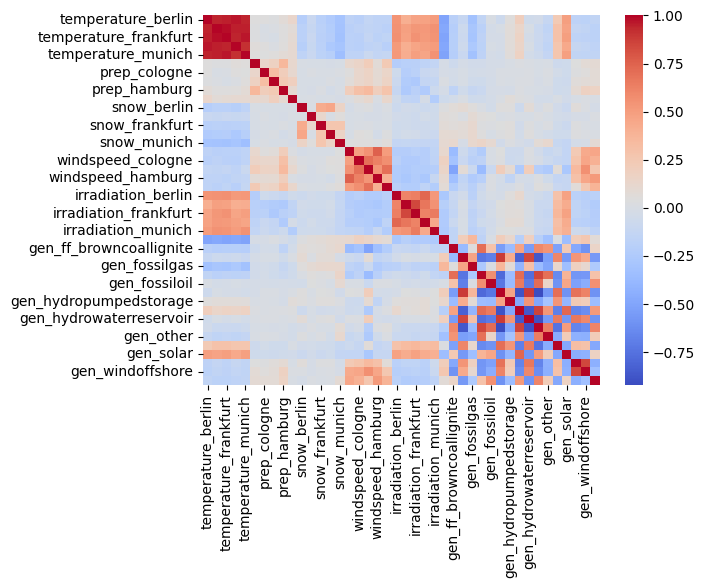

In [18]:
# First let's look at the correlation of all the features
sns.heatmap(X.corr(), cmap='coolwarm')

Takeaways: there are two distinct splits of data between weather metrics and power generation.

1. Weather features for given cities are highly correlated with eachother, such as temperature and irradiaton, but precipitation and snowfall are less so. Temperature and irraditiation are also correlated with eachother for a given city, which makes sense (if it's sunny, the temperature is higher, and vice-versa).
2. There are some high correlations among generation technologies too.
2. Let's split our features into two: weather and generation, remove some colinearity in those two cuts, and then consider the dataframe as a whole.

### Weather features

<Axes: >

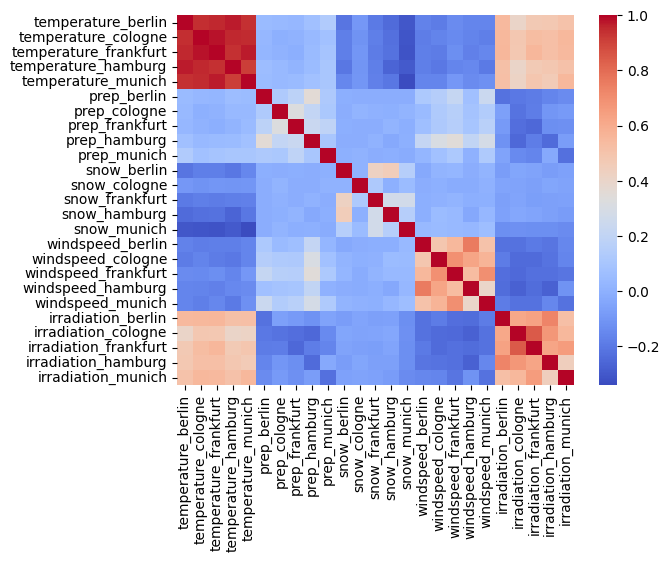

In [19]:
sns.heatmap(pd.DataFrame(X).iloc[:, 0: 25].corr(), cmap='coolwarm')

Conclusion: let's make a single feature for temperature, irradiation, and windspeed, and look at the matrix again. It will be the mean across the cities we have selected.

In [20]:
def average_weather(df: pd.DataFrame, measures: List[str]) -> pd.DataFrame:
    for measure in measures:
        col = f"{measure}_germany"
        df[col] = df[
            [c for c in df.columns if measure in c]
        ].mean(axis=1)
        df.drop(columns=[
            c for c in df.columns if measure in c and "germany" not in c
        ], inplace=True)
        df.insert(0, col, df.pop(col))
    return df

In [21]:
X = average_weather(X, ["temperature", "irradiation", "windspeed"])

<Axes: >

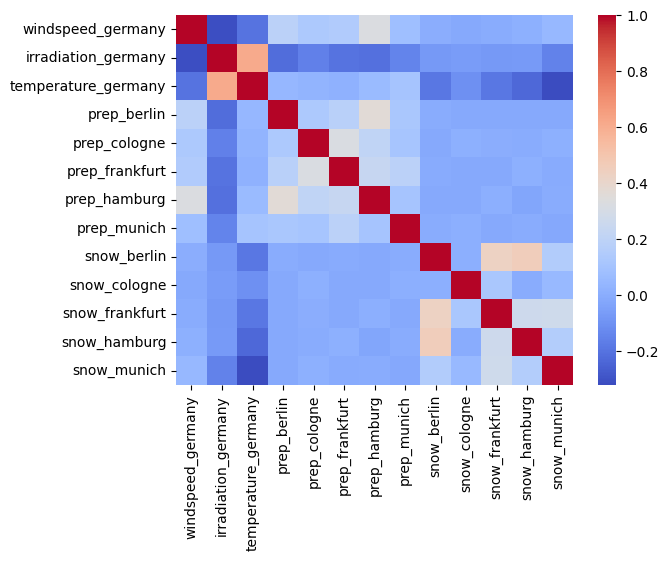

In [22]:
sns.heatmap(X.iloc[:, :13].corr(), cmap='coolwarm')

### Generation technologies correlation

<Axes: >

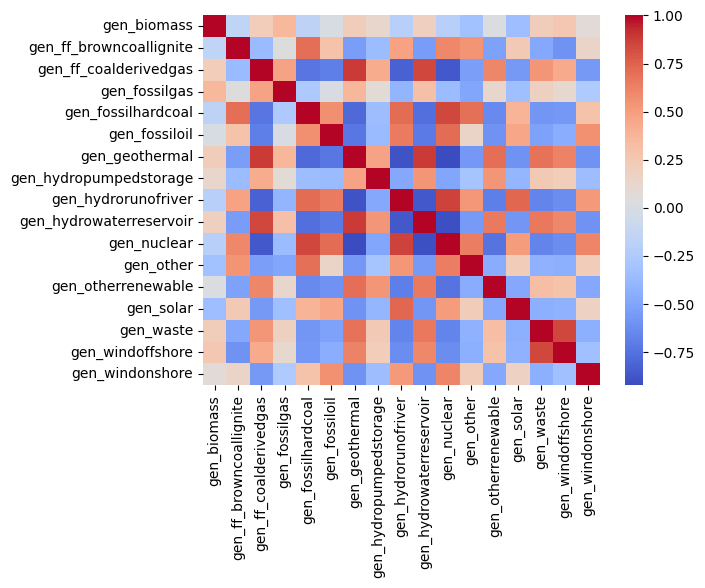

In [23]:
sns.heatmap(X.iloc[:, 13:].corr(), cmap='coolwarm')

Initially I thought about grouping some of these technologies (hydro, coal, gas, wind, etc.), but given the correlations between technologies aren't so obvious, I opted to leave them as is and let the PCA analysis make the decision.

## Scaling & PCA analysis

In order to run a PCA analysis, the data needs to be centered around the mean, so we use the StandardScaler() to scale the data.

In [24]:
X_features = list(X.columns)
scaler = StandardScaler()
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X), columns=X_features)

In [25]:
pca = PCA()
pca.fit(X)

# Access our 30 PCs 
W = pca.components_

# Print PCs as COLUMNS
W = pd.DataFrame(W.T,index=X_features, columns=[f'PC{i}' for i in range(1, 31)])
W

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30
windspeed_germany,0.040952,0.283452,-0.398037,-0.098887,0.269896,-0.184236,0.119600,-0.011765,-0.086826,-0.038230,...,0.228097,-0.211346,0.188962,0.044769,0.161539,0.337051,-0.059825,0.071798,0.332638,0.134428
irradiation_germany,-0.002698,-0.454823,0.029326,0.018043,0.296932,0.047252,0.051611,0.032577,-0.044578,0.151114,...,-0.214196,0.150726,0.064589,-0.037700,0.120284,-0.096540,0.046336,-0.235028,-0.081729,0.332542
temperature_germany,-0.012844,-0.442034,-0.226176,0.138504,0.105085,0.172226,-0.023151,0.057543,0.033082,-0.006996,...,0.366461,0.070196,0.383644,-0.048999,0.189073,-0.108813,0.014907,-0.046304,0.071676,0.042144
prep_berlin,0.003805,0.120249,-0.245508,0.200256,-0.123952,0.172471,-0.083865,0.093644,0.654411,-0.030011,...,-0.061398,0.026060,-0.003564,0.009795,-0.009287,-0.013245,-0.003157,-0.016577,-0.008686,-0.003935
prep_cologne,0.004176,0.101025,-0.193602,0.241942,-0.192169,0.254123,-0.022022,-0.018890,-0.411783,0.460822,...,-0.020224,0.003945,-0.013643,0.003315,-0.015064,-0.009587,0.011489,-0.007974,0.001722,0.002333
prep_frankfurt,0.007345,0.121409,-0.223011,0.260654,-0.212022,0.269277,-0.098995,-0.092072,-0.344127,0.166892,...,-0.017284,-0.015962,-0.005722,0.000869,0.011992,-0.000999,0.009678,-0.001566,0.005242,-0.006409
prep_hamburg,0.008071,0.145136,-0.339244,0.194227,-0.017671,0.116460,-0.052967,0.131246,0.385438,0.158228,...,-0.081359,0.021397,-0.005079,0.011689,0.000939,-0.000552,-0.010910,-0.002521,0.005958,0.003880
prep_munich,0.008006,0.032478,-0.148578,0.229910,-0.163205,0.243303,0.121768,-0.105920,-0.191510,-0.759480,...,-0.059957,0.059873,0.008518,-0.025024,0.015574,-0.034713,-0.001515,-0.020676,-0.011258,-0.018892
snow_berlin,0.015555,0.154187,0.205929,0.397766,0.373591,-0.007470,-0.128609,-0.071327,-0.001087,-0.089475,...,0.053906,-0.018418,-0.004120,0.018264,0.009760,-0.004800,-0.003102,0.010261,-0.012608,-0.008478
snow_cologne,-0.003451,0.069535,0.082358,-0.016532,-0.034476,0.134088,0.296223,0.827296,-0.169341,-0.128940,...,0.005007,0.012516,0.008622,-0.007682,-0.012051,-0.000215,0.000672,0.001216,0.000664,0.003912


<Axes: >

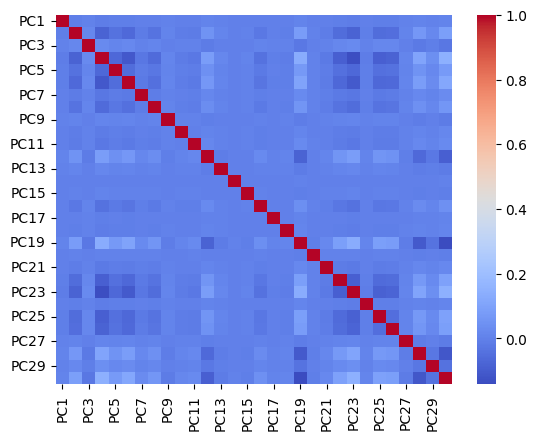

In [26]:
sns.heatmap(W.corr(), cmap='coolwarm')

In [27]:
pca.explained_variance_ratio_

array([0.30882458, 0.10706901, 0.08635407, 0.05535067, 0.05072113,
       0.04505949, 0.03601181, 0.03347193, 0.03206133, 0.03087184,
       0.02842724, 0.02395767, 0.02226883, 0.02200961, 0.02001316,
       0.01853998, 0.01579114, 0.01288149, 0.00978722, 0.00817704,
       0.00657539, 0.00547029, 0.00454968, 0.00379991, 0.00312225,
       0.00251754, 0.00212684, 0.00195838, 0.00145022, 0.00078025])

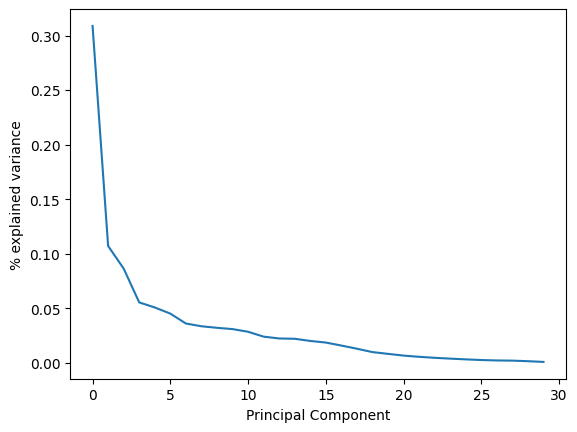

In [28]:
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Principal Component'); plt.ylabel('% explained variance');

Almost 50% of the variance in the dataset can be explained in the first three axes.

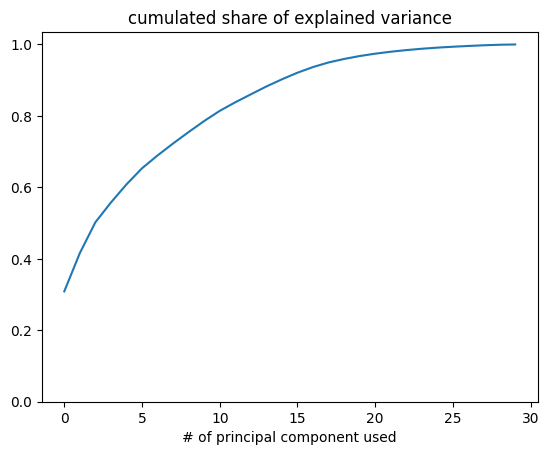

In [29]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylim(ymin=0)
plt.title('cumulated share of explained variance')
plt.xlabel('# of principal component used');

In [30]:
pca = PCA(n_components=25).fit(X) # Fit a PCA with  15 components
X_25 = pd.DataFrame(pca.fit_transform(X), columns=["PC" + str(i) for i in range(25)
]) # Project data into 25 dimensions
X_25

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24
0,-2.198591,4.087311,-0.727306,1.665139,0.985556,-1.527229,4.461545,-0.191334,0.094967,2.409726,...,-0.004203,1.361191,-0.995782,1.115884,0.676399,-0.074147,0.320580,-0.786288,-0.172650,-0.143755
1,-2.869508,0.323930,0.415819,0.689918,-1.108582,-2.179567,0.388070,-0.084443,0.380952,-0.069338,...,-0.643820,-0.358314,-0.028174,0.169484,-0.531828,-0.462301,0.395645,-0.357737,-0.089075,-0.811885
2,-3.191639,0.487580,0.888783,0.735971,-1.638215,-2.451996,-0.408588,0.192471,-0.110009,0.072255,...,-0.446347,-0.305507,0.542338,0.548201,-0.498891,-0.417385,-0.106492,-0.255439,-0.067384,-0.588235
3,-2.978643,0.699651,0.673810,0.913246,-1.634788,-2.144362,0.683484,-0.277556,-0.128065,0.022113,...,-1.038012,-0.422481,-0.109048,-0.245648,-0.516750,-0.191977,0.350671,-0.000721,-0.041530,-0.501415
4,-2.964315,2.481151,-2.772033,2.400119,-2.027455,-0.311034,0.300432,-0.055735,0.333301,1.832392,...,-0.526393,-0.355080,0.223120,-0.397443,-0.487877,-0.604050,0.245038,-0.030287,0.042447,-0.144760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2036,3.284921,2.111110,-1.908627,1.819022,-2.578903,2.597868,-0.917740,-0.481998,-0.879326,-1.098599,...,0.506071,0.096230,-0.019802,-0.023503,-0.598309,0.159574,-0.420748,0.295052,0.669825,-0.448397
2037,4.506205,1.195666,-1.322272,-1.189814,1.026764,-1.894852,-0.722293,0.588247,-0.488636,-0.235754,...,-0.302139,0.053975,0.401502,0.586771,-0.272611,0.030645,0.594653,-0.646426,0.777769,-0.164646
2038,4.600307,2.038314,-2.841648,-0.855162,1.210786,-2.140491,-0.849447,0.873772,-0.250338,-0.059364,...,-0.399363,0.063659,0.375011,0.836247,-0.112312,0.355555,0.170996,-0.468195,0.676559,-0.185493
2039,4.534784,1.663045,-2.766412,-0.936917,1.351930,-2.031004,-0.796585,0.764454,-0.425794,-0.462641,...,-0.606313,-0.057446,0.412202,0.814339,-0.361479,0.992864,-0.462743,-0.050034,0.802610,-0.146199


In [31]:
# Test PCA data
X_train, X_test, y_train, y_test = train_test_split(X_25, y, test_size=0.3)
model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_test,y_test)

0.6691635930329223

In [32]:
# Compared to no PCA analysis with all features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.6605703951762734

Conclusion: I think let's ignore the option to reduce features with PCA analysis, and just use it to remove correlation between features.

# Build pipeline

To build pipeline:

1. fill null values for snow columns with 0 using SimpleImputer.
2. apply shifted() method to two other columns with null values using FunctionTransformer.
3. Average temperature, windspeed and irradiation with average_weather() method, using FunctionTransformer.
4. Scale all features for PCA analysis with StandardScaler.
5. Build in PCA analysis.
6. Add back in date column?

In [33]:
snow_imputer = SimpleImputer(strategy="constant", fill_value=0)

In [34]:
preprocessor = ColumnTransformer([
    ("snow_transformer", snow_imputer, [col for col in df.columns if "snow" in col]),
],
    remainder="passthrough",)
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('snow_transformer',
                                 SimpleImputer(fill_value=0,
                                               strategy='constant'),
                                 ['snow_berlin', 'snow_cologne',
                                  'snow_frankfurt', 'snow_hamburg',
                                  'snow_munich'])])

# Appendix: Charting

In [35]:
def plot_weather_patterns(city: str):

    temp = [col for col in df.columns if city in col and "temperature" in col]
    prep = [col for col in df.columns if city in col and "prep" in col]
    wind = [col for col in df.columns if city in col and "windspeed" in col]
    snow = [col for col in df.columns if city in col and "snow" in col]
    irr = [col for col in df.columns if city in col and "irradiation" in col]

    # Start figure
    plt.figure(figsize=(10,15))

    # Temperature
    plt.subplot(5, 1, 1)
    plt.plot(df.date, df[temp], c="black", linewidth=0.5)
    plt.title("Average temperature")
    # Precipitation
    plt.subplot(5, 1, 2)
    plt.plot(df.date, df[prep], c='black', linewidth=0.5)
    plt.title("Precipitation")
    # Wind speed
    plt.subplot(5, 1, 3)
    plt.plot(df.date, df[wind], c='black', linewidth=0.5)
    plt.title("Wind speed")
    # Snow fall
    plt.subplot(5, 1, 4)
    plt.plot(df.date, df[snow], c='black', linewidth=0.5)
    plt.title("Snow")
    # Solar irradiation
    plt.subplot(5, 1, 5)
    plt.plot(df.date, df[irr], c='black', linewidth=0.5)
    plt.title("Solar irradiation")
    
    plt.show();

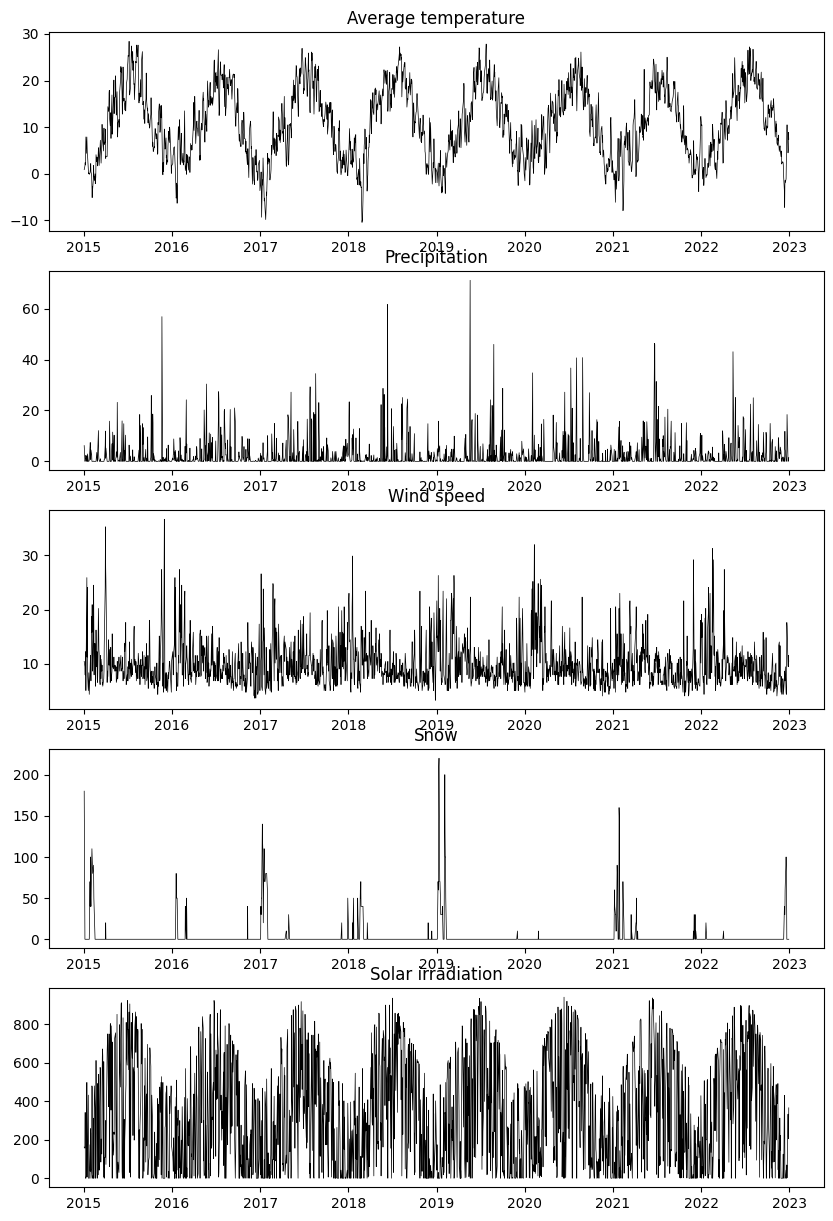

In [36]:
plot_weather_patterns("munich")

# Model LSTM and RNN


TN: Assuming Preprocessing is done

In [37]:
##RNN

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.optimizers import Adam
X_new = X.values
y_new = y.values

split = int(0.8 * len(X))  
X_train, X_test = X_new[:split], X_new[split:]
y_train, y_test = y_new[:split], y_new[split:]

# Reshape
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# RNN model
model_RNN = Sequential()
model_RNN.add(SimpleRNN(units=32, input_shape=(1, X_train.shape[2])))
model_RNN.add(Dense(10, activation='relu'))
model_RNN.add(Dense(units=1))

# Compile
model_RNN.compile(loss='mean_squared_error', optimizer='rmsprop')

# Train the model_RNN
model_RNN.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)


loss = model_RNN.evaluate(X_test, y_test, verbose=0)
print('Test Loss:', loss)

2023-06-25 21:12:12.214906: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-25 21:12:12.354404: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-25 21:12:12.360535: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-25 21:12:12.360552: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

Epoch 1/100


2023-06-25 21:12:13.531353: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-06-25 21:12:13.531398: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-06-25 21:12:13.531420: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Tobi): /proc/driver/nvidia/version does not exist
2023-06-25 21:12:13.531785: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


51/51 [==============================] - 1s 2ms/step - loss: 1452.4160
Epoch 2/100
51/51 [==============================] - 0s 2ms/step - loss: 1327.3463
Epoch 3/100
51/51 [==============================] - 0s 1ms/step - loss: 1187.3850
Epoch 4/100
51/51 [==============================] - 0s 1ms/step - loss: 1035.2433
Epoch 5/100
51/51 [==============================] - 0s 1ms/step - loss: 871.9892
Epoch 6/100
51/51 [==============================] - 0s 1ms/step - loss: 696.9048
Epoch 7/100
51/51 [==============================] - 0s 1ms/step - loss: 519.1735
Epoch 8/100
51/51 [==============================] - 0s 1ms/step - loss: 360.0904
Epoch 9/100
51/51 [==============================] - 0s 1ms/step - loss: 231.3545
Epoch 10/100
51/51 [==============================] - 0s 1ms/step - loss: 146.2014
Epoch 11/100
51/51 [==============================] - 0s 1ms/step - loss: 106.8997
Epoch 12/100
51/51 [==============================] - 0s 1ms/step - loss: 96.6011
Epoch 13/100
51/51 [==

Test Loss: 50513.1328125


with dummy X and Y are bad result in loss


In [38]:
model_RNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                2016      
                                                                 
 dense (Dense)               (None, 10)                330       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 2,357
Trainable params: 2,357
Non-trainable params: 0
_________________________________________________________________


13/13 [==============================] - 0s 1ms/step


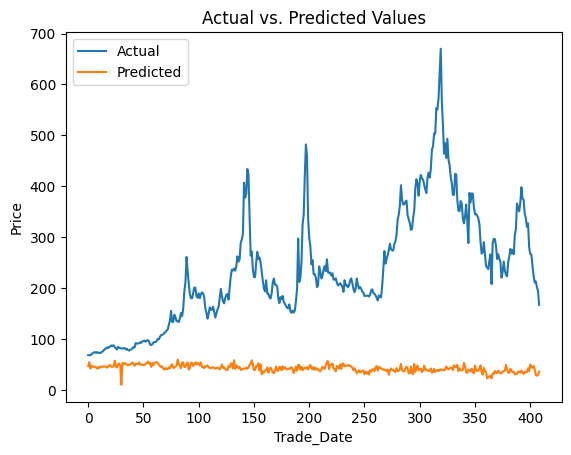

In [39]:
y_pred = model_RNN.predict(X_test)

y_pred = y_pred.reshape(-1)
y_test = y_test.reshape(-1)

plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Trade_Date')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()

Epoch 1/100
51/51 [==============================] - 1s 2ms/step - loss: 1450.6841
Epoch 2/100
51/51 [==============================] - 0s 2ms/step - loss: 1298.1077
Epoch 3/100
51/51 [==============================] - 0s 2ms/step - loss: 1088.5957
Epoch 4/100
51/51 [==============================] - 0s 2ms/step - loss: 863.3599
Epoch 5/100
51/51 [==============================] - 0s 2ms/step - loss: 661.0640
Epoch 6/100
51/51 [==============================] - 0s 2ms/step - loss: 508.1006
Epoch 7/100
51/51 [==============================] - 0s 2ms/step - loss: 414.4084
Epoch 8/100
51/51 [==============================] - 0s 2ms/step - loss: 380.8783
Epoch 9/100
51/51 [==============================] - 0s 3ms/step - loss: 366.5845
Epoch 10/100
51/51 [==============================] - 0s 2ms/step - loss: 351.2337
Epoch 11/100
51/51 [==============================] - 0s 2ms/step - loss: 335.1770
Epoch 12/100
51/51 [==============================] - 0s 2ms/step - loss: 319.1540
Epoch 13/1

51/51 [==============================] - 0s 2ms/step - loss: 17.0754
Test Loss: 50449.76171875
13/13 [==============================] - 0s 1ms/step


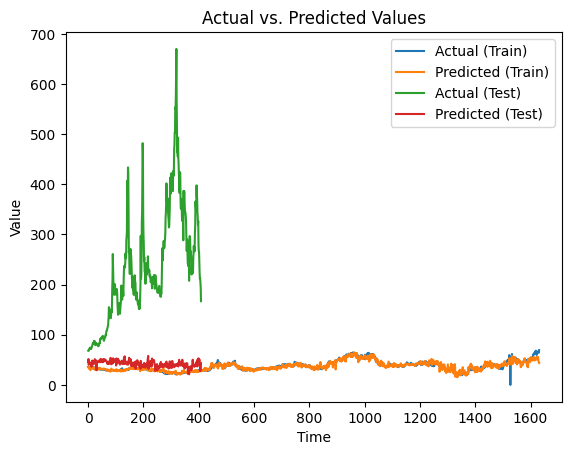

In [40]:
####LSTM
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# LSTM model_LSTM
model_LSTM = Sequential()
model_LSTM.add(LSTM(units=32, input_shape=(1, X_train.shape[2])))
model_LSTM.add(Dense(10, activation='relu'))
model_LSTM.add(Dense(units=1))

# Compile
model_LSTM.compile(loss='mean_squared_error', optimizer='rmsprop')

# Train the model_LSTM
model_LSTM.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

# Evaluate
loss = model_LSTM.evaluate(X_test, y_test, verbose=0)
print('Test Loss:', loss)

# Get predictions on the train and test sets
y_train_pred = model_LSTM.predict(X_train)
y_test_pred = model_LSTM.predict(X_test)

# Reshape
y_train_pred = y_train_pred.reshape(-1)
y_test_pred = y_test_pred.reshape(-1)
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

plt.plot(y_train, label='Actual (Train)')
plt.plot(y_train_pred, label='Predicted (Train)')

plt.plot(y_test, label='Actual (Test)')
plt.plot(y_test_pred, label='Predicted (Test)')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()

Loss of LSTM is slightly better 48843.339 vs. 50717.75

13/13 [==============================] - 0s 2ms/step


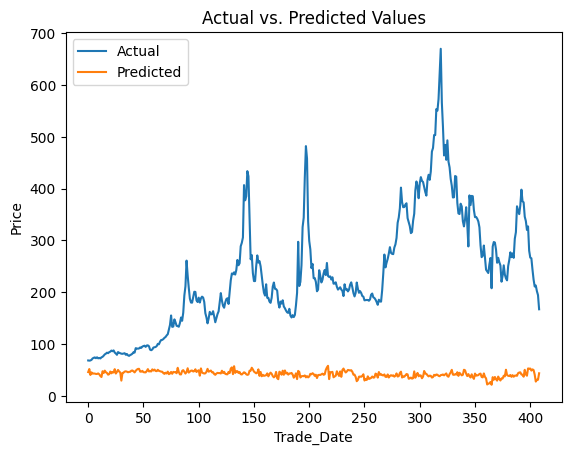

In [41]:
y_pred = model_LSTM.predict(X_test)

y_pred = y_pred.reshape(-1)
y_test = y_test.reshape(-1)

plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Trade_Date')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()


# Model LSTM and RNN 
New Try with log of our target

In [42]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.optimizers import Adam
X_new = X.values
y_new = y.values

split = int(0.8 * len(X))  
X_train, X_test = X_new[:split], X_new[split:]
y_train, y_test = y_new[:split], y_new[split:]

#try to do the log
epsilon = 1e-8  # there are some 0 Values in the dataframe. Cannot work then
y_train = np.log(y_train + epsilon)
y_test = np.log(y_test + epsilon)

# Reshape
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# RNN model
model_RNN = Sequential()
model_RNN.add(SimpleRNN(units=32, input_shape=(1, X_train.shape[2])))
model_RNN.add(Dense(10, activation='relu'))
model_RNN.add(Dense(units=1))

# Compile
model_RNN.compile(loss='mean_squared_error', optimizer='rmsprop')

# Train the model_RNN
model_RNN.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)


loss = model_RNN.evaluate(X_test, y_test, verbose=0)
print('Test Loss:', loss)

Epoch 1/100
51/51 [==============================] - 1s 1ms/step - loss: 9.3432
Epoch 2/100
51/51 [==============================] - 0s 1ms/step - loss: 1.8552
Epoch 3/100
51/51 [==============================] - 0s 1ms/step - loss: 0.5175
Epoch 4/100
51/51 [==============================] - 0s 1ms/step - loss: 0.4194
Epoch 5/100
51/51 [==============================] - 0s 1ms/step - loss: 0.3788
Epoch 6/100
51/51 [==============================] - 0s 1ms/step - loss: 0.3610
Epoch 7/100
51/51 [==============================] - 0s 2ms/step - loss: 0.3496
Epoch 8/100
51/51 [==============================] - 0s 1ms/step - loss: 0.3435
Epoch 9/100
51/51 [==============================] - 0s 1ms/step - loss: 0.3352
Epoch 10/100
51/51 [==============================] - 0s 1ms/step - loss: 0.3311
Epoch 11/100
51/51 [==============================] - 0s 1ms/step - loss: 0.3297
Epoch 12/100
51/51 [==============================] - 0s 1ms/step - loss: 0.3241
Epoch 13/100
51/51 [=================

13/13 [==============================] - 0s 1ms/step


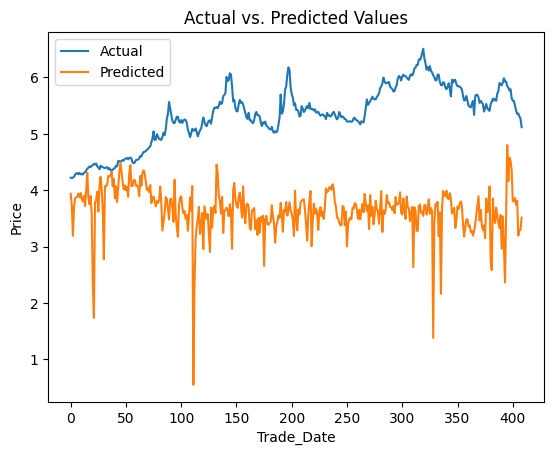

In [43]:
y_pred = model_RNN.predict(X_test)

y_pred = y_pred.reshape(-1)
y_test = y_test.reshape(-1)

plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Trade_Date')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()

Epoch 1/100
51/51 [==============================] - 1s 2ms/step - loss: 10.0498
Epoch 2/100
51/51 [==============================] - 0s 2ms/step - loss: 4.0623
Epoch 3/100
51/51 [==============================] - 0s 2ms/step - loss: 1.2882
Epoch 4/100
51/51 [==============================] - 0s 2ms/step - loss: 0.5514
Epoch 5/100
51/51 [==============================] - 0s 2ms/step - loss: 0.4064
Epoch 6/100
51/51 [==============================] - 0s 2ms/step - loss: 0.3731
Epoch 7/100
51/51 [==============================] - 0s 2ms/step - loss: 0.3554
Epoch 8/100
51/51 [==============================] - 0s 2ms/step - loss: 0.3452
Epoch 9/100
51/51 [==============================] - 0s 2ms/step - loss: 0.3384
Epoch 10/100
51/51 [==============================] - 0s 2ms/step - loss: 0.3354
Epoch 11/100
51/51 [==============================] - 0s 2ms/step - loss: 0.3322
Epoch 12/100
51/51 [==============================] - 0s 2ms/step - loss: 0.3293
Epoch 13/100
51/51 [================

13/13 [==============================] - 0s 2ms/step


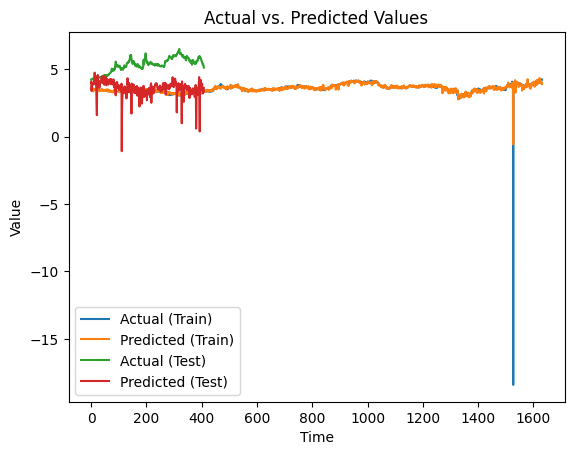

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# LSTM model_LSTM
model_LSTM = Sequential()
model_LSTM.add(LSTM(units=32, input_shape=(1, X_train.shape[2])))
model_LSTM.add(Dense(10, activation='relu'))
model_LSTM.add(Dense(units=1))

# Compile
model_LSTM.compile(loss='mean_squared_error', optimizer='rmsprop')

# Train the model_LSTM
model_LSTM.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

# Evaluate
loss = model_LSTM.evaluate(X_test, y_test, verbose=0)
print('Test Loss:', loss)

# Get predictions on the train and test sets
y_train_pred = model_LSTM.predict(X_train)
y_test_pred = model_LSTM.predict(X_test)

# Reshape
y_train_pred = y_train_pred.reshape(-1)
y_test_pred = y_test_pred.reshape(-1)
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

plt.plot(y_train, label='Actual (Train)')
plt.plot(y_train_pred, label='Predicted (Train)')

plt.plot(y_test, label='Actual (Test)')
plt.plot(y_test_pred, label='Predicted (Test)')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()

13/13 [==============================] - 0s 1ms/step


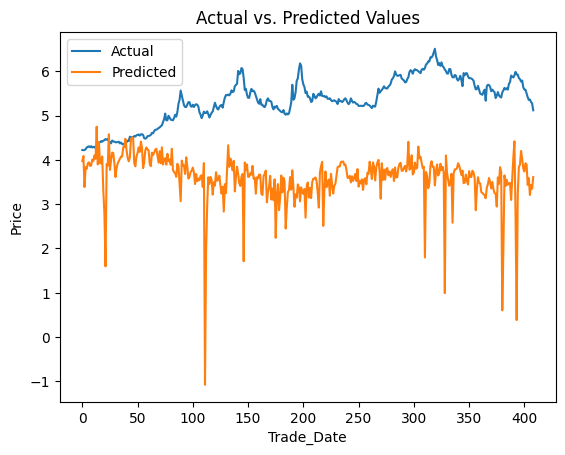

In [45]:
y_pred = model_LSTM.predict(X_test)

y_pred = y_pred.reshape(-1)
y_test = y_test.reshape(-1)

plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Trade_Date')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()

In [46]:
X

,windspeed_germany,irradiation_germany,temperature_germany,prep_berlin,prep_cologne,prep_frankfurt,prep_hamburg,prep_munich,snow_berlin,snow_cologne,...,gen_hydropumpedstorage,gen_hydrorunofriver,gen_hydrowaterreservoir,gen_nuclear,gen_other,gen_otherrenewable,gen_solar,gen_waste,gen_windoffshore,gen_windonshore
0,2.099506,-1.090796,-1.026486,-0.077037,0.136639,0.912288,0.486628,0.639738,-0.112824,-0.070307,...,-0.803470,-0.033125,-0.748961,0.840346,1.297501,-0.606028,-0.946683,-0.634565,-0.703821,2.642173
1,-0.180482,-0.457104,-1.236719,0.231495,-0.371704,-0.419051,-0.497843,-0.422062,-0.112824,-0.070307,...,-0.444301,0.550143,-0.753672,1.315653,2.169653,-0.602254,-0.667166,-0.611825,-0.718728,0.573490
2,-0.375481,-0.902260,-1.441270,-0.361836,-0.044912,-0.419051,-0.374784,-0.422062,-0.112824,-0.070307,...,-1.495545,0.431775,-0.749199,1.383551,2.341976,-0.602106,-0.572346,-0.587546,-0.725548,-0.188755
3,0.004517,-0.876074,-1.194104,-0.266903,0.209260,-0.342243,-0.473231,-0.233678,-0.112824,-0.070307,...,0.222785,0.391788,-0.748307,1.391978,2.446327,-0.601746,-0.807310,-0.587560,-0.701890,0.513507
4,1.294511,-1.305518,-0.890119,1.916553,2.968834,1.373136,1.963335,-0.250804,-0.112824,-0.070307,...,-0.570582,0.398903,-0.744639,1.369696,1.878962,-0.604548,-0.934181,-0.553277,-0.691840,1.729718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2036,0.144517,-1.303773,-0.435561,1.987753,1.080704,4.163828,0.462016,2.729086,-0.112824,-0.070307,...,0.248412,-1.314342,0.393252,-1.232906,-0.762720,-0.489794,-0.778048,0.057323,0.921488,-0.810605
2037,0.894513,-0.407351,-0.952621,-0.361836,-0.371704,-0.419051,0.265122,-0.422062,-0.112824,-0.070307,...,0.467879,-1.275948,0.385480,-1.263226,-0.778691,-0.026811,-0.778253,2.760843,2.606397,-0.810605
2038,1.799508,-1.116982,-0.648635,-0.005837,0.154794,-0.393448,1.397264,-0.422062,-0.112824,-0.070307,...,0.371262,-1.280870,0.377806,-1.263270,-0.778788,-0.253183,-0.862861,2.889474,3.389085,-0.810605
2039,2.189506,-1.000019,-0.233852,0.065362,-0.353548,-0.035011,0.560464,-0.216552,-0.112824,-0.070307,...,0.078801,-1.291823,0.367777,-1.265150,-0.779056,-0.250211,-0.796849,1.953701,3.654241,-0.810605
